# Install & Import Library

## Install Library

In [1]:
!pip install google-play-scraper 

In [ ]:
!pip install wordcloud
!pip install tqdm
!pip install nltk
!pip install transformers

In [ ]:
!pip install bertopic

## Import Library

In [2]:
from google_play_scraper import Sort, reviews
import pandas as pd

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import re
import string
from tqdm import tqdm
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import pipeline
tqdm.pandas()
import asyncio
import time
import transformers
from wordcloud import WordCloud, STOPWORDS

In [ ]:
from bertopic import BERTopic
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance
from umap import UMAP

# Scraping Data

In [3]:
result = reviews(
    'com.gojek.gopay',
    lang='id',
    country='id',
    sort=Sort.MOST_RELEVANT,
    count=7000
)

In [4]:
result = pd.DataFrame(result[0])
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              7000 non-null   object        
 1   userName              7000 non-null   object        
 2   userImage             7000 non-null   object        
 3   content               7000 non-null   object        
 4   score                 7000 non-null   int64         
 5   thumbsUpCount         7000 non-null   int64         
 6   reviewCreatedVersion  6921 non-null   object        
 7   at                    7000 non-null   datetime64[ns]
 8   replyContent          4529 non-null   object        
 9   repliedAt             4529 non-null   datetime64[ns]
 10  appVersion            6921 non-null   object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 601.7+ KB


In [5]:
data = result.to_csv('result.csv', index=False)

# Data Cleaning

In [6]:
data = pd.read_csv('result.csv')
data = data.drop(['reviewId','userName', 'userImage', 'reviewCreatedVersion', 'replyContent', 'repliedAt'],axis=1)

In [7]:
data = data.drop_duplicates()
data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6921 entries, 0 to 6999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   content        6921 non-null   object
 1   score          6921 non-null   int64 
 2   thumbsUpCount  6921 non-null   int64 
 3   at             6921 non-null   object
 4   appVersion     6921 non-null   object
dtypes: int64(2), object(3)
memory usage: 324.4+ KB


In [8]:
data['at'] = pd.to_datetime(data['at'])
data = data[data['at'].dt.year == 2025]

data['month'] = data['at'].dt.month.astype('str')
data = data.drop(columns=['at'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6921 entries, 0 to 6999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   content        6921 non-null   object
 1   score          6921 non-null   int64 
 2   thumbsUpCount  6921 non-null   int64 
 3   appVersion     6921 non-null   object
 4   month          6921 non-null   object
dtypes: int64(2), object(3)
memory usage: 324.4+ KB


In [9]:
data.head()

,content,score,thumbsUpCount,appVersion,month
0,"aplikasinya bagus aja, cuma ad sedikit masalah...",3,28,1.56.1,8
1,utamakan efektivitas tolong kurangi animasi yg...,3,3,1.57.0,8
2,aplikasi nya udh bagus seperti yang lainnya ta...,2,26,1.56.1,8
3,Cukup kecewa update kali ini. Mengapa sistem b...,2,22,1.56.1,8
4,"promo tak sesuai kenyataan, harga ternyata leb...",1,26,1.53.0,8


In [10]:
print(data['appVersion'].unique())

['1.56.1' '1.57.0' '1.53.0' '1.52.0' '1.54.0' '1.51.0' '1.49.1' '1.49.0'
 '1.48.0' '1.45.0' '1.47.0' '1.46.1' '1.44.0' '1.56.0' '1.39.0' '1.26.1'
 '1.15.1' '1.21.0']


In [11]:
data['minorVersion'] = data['appVersion']
data = data.drop(columns=['appVersion'], axis=1)
data['majorVersion'] = data['minorVersion'].str[:3]
data.head()

,content,score,thumbsUpCount,month,minorVersion,majorVersion
0,"aplikasinya bagus aja, cuma ad sedikit masalah...",3,28,8,1.56.1,1.5
1,utamakan efektivitas tolong kurangi animasi yg...,3,3,8,1.57.0,1.5
2,aplikasi nya udh bagus seperti yang lainnya ta...,2,26,8,1.56.1,1.5
3,Cukup kecewa update kali ini. Mengapa sistem b...,2,22,8,1.56.1,1.5
4,"promo tak sesuai kenyataan, harga ternyata leb...",1,26,8,1.53.0,1.5


In [12]:
print(data['majorVersion'].unique())

['1.5' '1.4' '1.3' '1.2' '1.1']


# Exploratory Data Analysis

In [14]:
data.describe()

,score,thumbsUpCount
count,6921.000000,6921.000000
mean,2.619853,6.478255
std,1.781197,32.648892
min,1.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,0.000000
75%,5.000000,2.000000
max,5.000000,1419.000000


<Axes: xlabel='score', ylabel='count'>

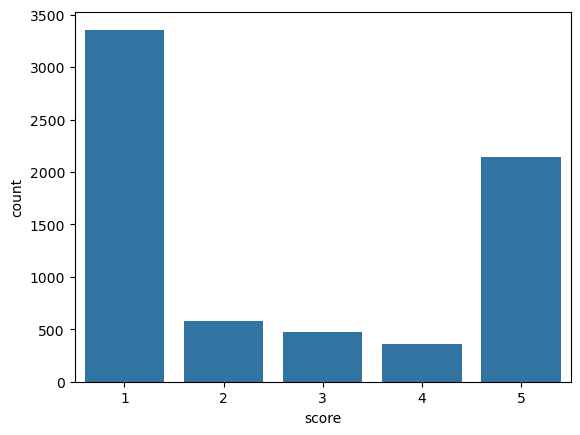

In [15]:
sns.countplot(data=data, x='score')

<Axes: xlabel='month', ylabel='count'>

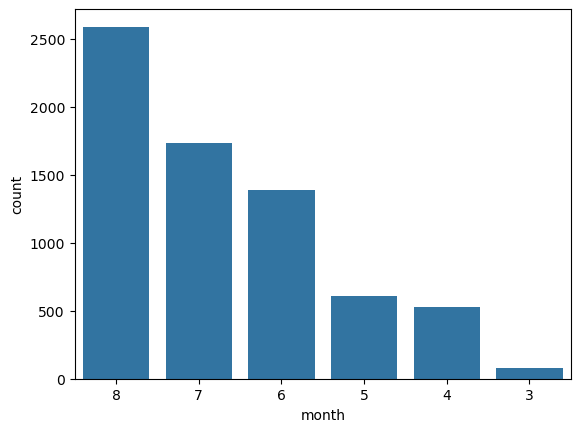

In [16]:
sns.countplot(data=data, x='month')

<Axes: xlabel='majorVersion', ylabel='count'>

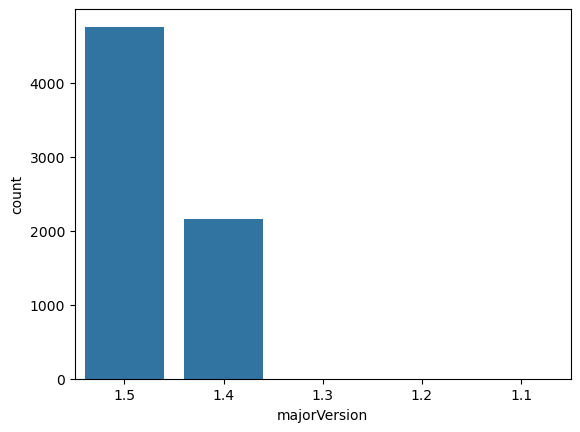

In [17]:
sns.countplot(data=data, x='majorVersion')

<Axes: xlabel='score', ylabel='thumbsUpCount'>

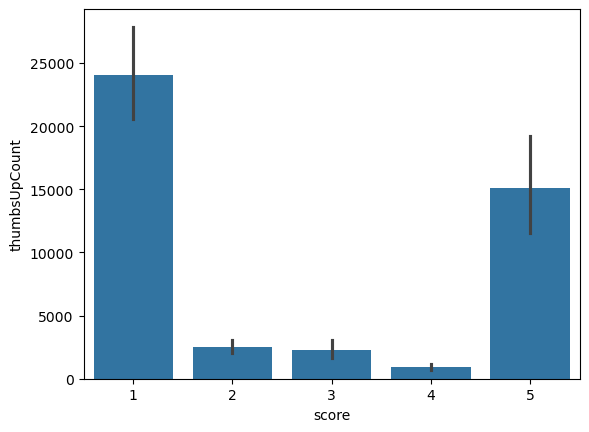

In [81]:
sns.barplot(data=data, x='score', y='thumbsUpCount', estimator="sum")

<Axes: xlabel='majorVersion', ylabel='score'>

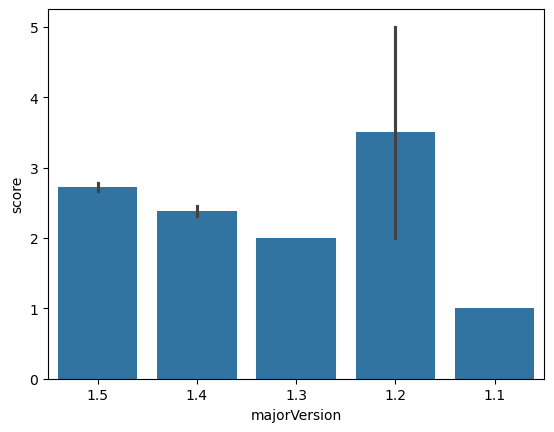

In [19]:
sns.barplot(data=data, x='majorVersion', y='score')

<Axes: xlabel='month', ylabel='Count'>

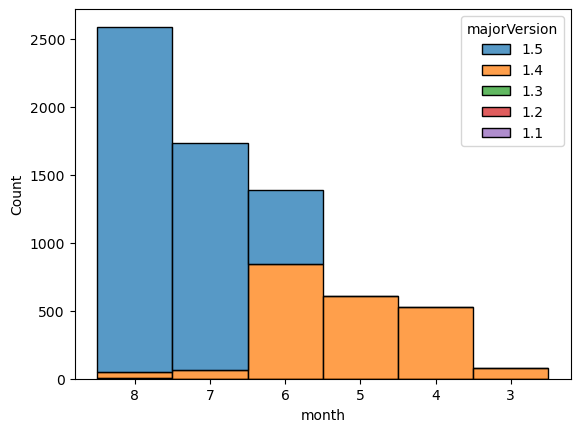

In [20]:
sns.histplot(data=data, x='month', hue='majorVersion', multiple="stack")

In [21]:
data.pivot_table(index='majorVersion',
                columns='month',
                values='score',
                aggfunc='mean')

month,3,4,5,6,7,8
majorVersion,,,,,,
1.1,NaN,NaN,NaN,NaN,NaN,1.000000
1.2,NaN,NaN,5.000000,NaN,NaN,2.000000
1.3,NaN,NaN,NaN,NaN,2.000000,NaN
1.4,2.101266,2.446768,2.362438,2.329370,2.733333,3.083333
1.5,NaN,NaN,NaN,2.158088,2.709851,2.858100


# Sentiment Analysis

In [27]:
translator = pipeline(
    "translation",
    model="facebook/nllb-200-distilled-600M",
    src_lang="ind_Latn",
    tgt_lang="eng_Latn"
)

config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
pipe = pipeline("text-classification", model="siebert/sentiment-roberta-large-english")

In [28]:
def translate(text):
  return translator(text)[0]["translation_text"]

def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip(' ')
    return text

def casefoldingText(text):
    text = text.lower()
    return text

def tokenizing(text):
  tokens = word_tokenize(text)
  return tokens

def stopwordstext(text):
  stop_words = set(stopwords.words('english'))
  filtered_tokens = [word for word in text if word not in stop_words]
  return filtered_tokens

def lemitizing(text):
  lemmatizer = WordNetLemmatizer()
  processed_text = [lemmatizer.lemmatize(word) for word in text]
  processed_text = " ".join(processed_text)
  return processed_text

def sentimenttext(text):
  result = pipe(text)
  return result[0]['label']

In [30]:
docs = pd.DataFrame(data['content'].reset_index(drop=True), columns=['content'])

docs['text_translate'] = docs['content'].progress_apply(translate)
docs['text_clean'] = docs['text_translate'].progress_apply(cleaningText)
docs['text_lower'] = docs['text_clean'].progress_apply(casefoldingText)
docs['text_tokenizing'] = docs['text_lower'].progress_apply(tokenizing)
docs['text_stopwords'] = docs['text_tokenizing'].progress_apply(stopwordstext)
docs['text_lemitizing'] = docs['text_stopwords'].progress_apply(lemitizing)
docs['text_label'] = docs['text_lemitizing'].progress_apply(sentimenttext)

 46% 3202/6921 [10:23<08:38,  7.17it/s]Your input_length: 183 is bigger than 0.9 * max_length: 200. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
 58% 4014/6921 [13:07<07:32,  6.42it/s]Your input_length: 228 is bigger than 0.9 * max_length: 200. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
100% 6921/6921 [19:59<00:00,  5.77it/s]
100% 6921/6921 [00:00<00:00, 170015.45it/s]
100% 6921/6921 [00:00<00:00, 3170465.05it/s]
100% 6921/6921 [00:00<00:00, 34644.10it/s]
100% 6921/6921 [00:00<00:00, 44271.90it/s]
100% 6921/6921 [00:01<00:00, 6108.01it/s]
100% 6921/6921 [00:24<00:00, 282.04it/s]


In [31]:
docs.head()

,content,text_translate,text_clean,text_lower,text_tokenizing,text_stopwords,text_lemitizing,text_label
0,"aplikasinya bagus aja, cuma ad sedikit masalah...","It's a good app, but it's just a little bit of...",Its a good app but its just a little bit of a ...,its a good app but its just a little bit of a ...,"[its, a, good, app, but, its, just, a, little,...","[good, app, little, bit, problem, trying, pay,...",good app little bit problem trying pay topup g...,POSITIVE
1,utamakan efektivitas tolong kurangi animasi yg...,please reduce the unnecessary animation to lig...,please reduce the unnecessary animation to lig...,please reduce the unnecessary animation to lig...,"[please, reduce, the, unnecessary, animation, ...","[please, reduce, unnecessary, animation, light...",please reduce unnecessary animation lighten ap...,NEGATIVE
2,aplikasi nya udh bagus seperti yang lainnya ta...,"The app is just as good as the others, but the...",The app is just as good as the others but ther...,the app is just as good as the others but ther...,"[the, app, is, just, as, good, as, the, others...","[app, good, others, theres, lot, weirdness, li...",app good others there lot weirdness like spin ...,NEGATIVE
3,Cukup kecewa update kali ini. Mengapa sistem b...,I'm pretty disappointed with the update this t...,Im pretty disappointed with the update this ti...,im pretty disappointed with the update this ti...,"[im, pretty, disappointed, with, the, update, ...","[im, pretty, disappointed, update, time, curre...",im pretty disappointed update time current gop...,NEGATIVE
4,"promo tak sesuai kenyataan, harga ternyata leb...","The promo is unrealistic, the price turns out ...",The promo is unrealistic the price turns out t...,the promo is unrealistic the price turns out t...,"[the, promo, is, unrealistic, the, price, turn...","[promo, unrealistic, price, turns, expensive, ...",promo unrealistic price turn expensive app ive...,NEGATIVE
...,...,...,...,...,...,...,...,...
6916,Saya transfer ke Gopay saya belum masuk2 udh d...,"I'm transferring to Gopay, I haven't been in s...",Im transferring to Gopay I havent been in sinc...,im transferring to gopay i havent been in sinc...,"[im, transferring, to, gopay, i, havent, been,...","[im, transferring, gopay, havent, since, pm]",im transferring gopay havent since pm,NEGATIVE
6917,jangan ada lagi yang downlod apk gojeck dan se...,Don't let anyone else download apk gojeck and ...,Dont let anyone else download apk gojeck and s...,dont let anyone else download apk gojeck and s...,"[dont, let, anyone, else, download, apk, gojec...","[dont, let, anyone, else, download, apk, gojec...",dont let anyone else download apk gojeck stuff...,NEGATIVE
6918,ga jelas masa udh effort nunggu sampe jam 17.0...,It's not clear how long the effort will wait t...,Its not clear how long the effort will wait ti...,its not clear how long the effort will wait ti...,"[its, not, clear, how, long, the, effort, will...","[clear, long, effort, wait, till, g, get, wdp,...",clear long effort wait till g get wdp rupiah u...,NEGATIVE
6919,mantap aplikasi nya sederhana tapi keren gaya ...,It's a simple but cool modern style feature ab...,Its a simple but cool modern style feature abu...,its a simple but cool modern style feature abu...,"[its, a, simple, but, cool, modern, style, fea...","[simple, cool, modern, style, feature, abundan...",simple cool modern style feature abundant gopa...,POSITIVE


In [32]:
data = data.reset_index(drop=True)
docs = docs.reset_index(drop=True)
data['labels'] = docs['text_label']
data.head()

,content,score,thumbsUpCount,month,minorVersion,majorVersion,labels
0,"aplikasinya bagus aja, cuma ad sedikit masalah...",3,28,8,1.56.1,1.5,POSITIVE
1,utamakan efektivitas tolong kurangi animasi yg...,3,3,8,1.57.0,1.5,NEGATIVE
2,aplikasi nya udh bagus seperti yang lainnya ta...,2,26,8,1.56.1,1.5,NEGATIVE
3,Cukup kecewa update kali ini. Mengapa sistem b...,2,22,8,1.56.1,1.5,NEGATIVE
4,"promo tak sesuai kenyataan, harga ternyata leb...",1,26,8,1.53.0,1.5,NEGATIVE


<Axes: xlabel='labels', ylabel='count'>

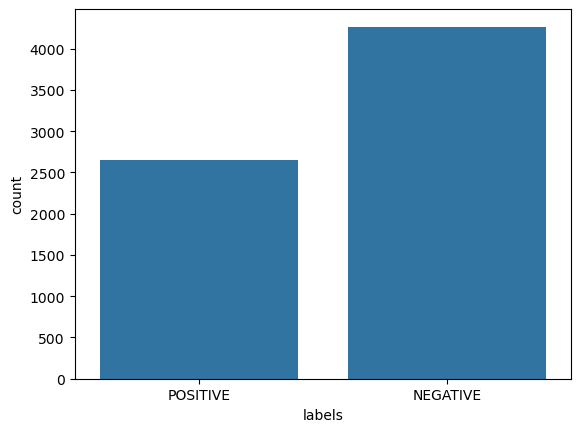

In [33]:
sns.countplot(data=data, x='labels')

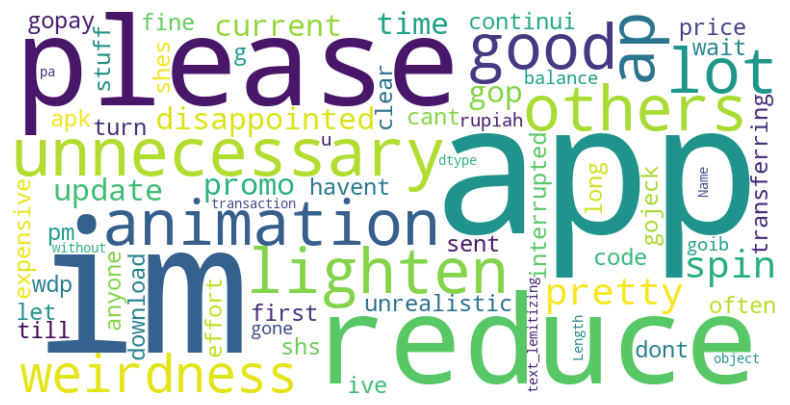

In [34]:
wordcloud = WordCloud(width=800, height=400, background_color="white", stopwords=STOPWORDS).generate(str(docs[docs['text_label']=='NEGATIVE']['text_lemitizing']))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

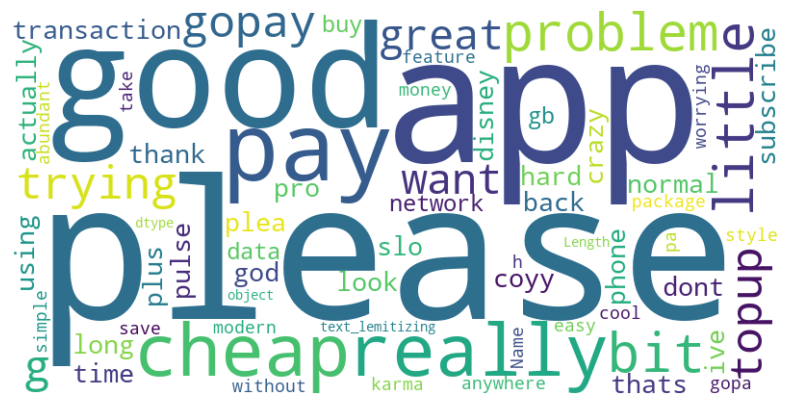

In [35]:
wordcloud = WordCloud(width=800, height=400, background_color="white", stopwords=STOPWORDS).generate(str(docs[docs['text_label']=='POSITIVE']['text_lemitizing']))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<Axes: xlabel='labels', ylabel='score'>

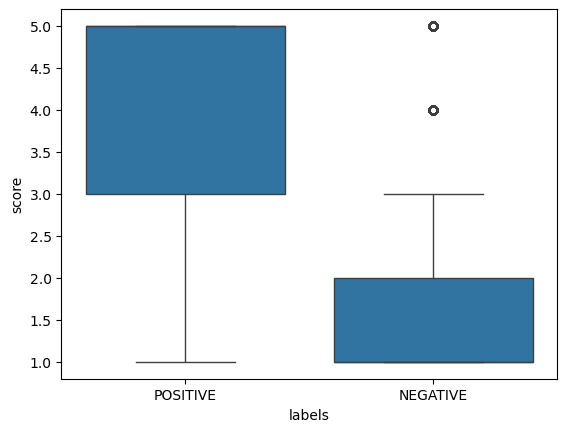

In [36]:
sns.boxplot(data=data, x='labels', y='score')

<Axes: xlabel='month', ylabel='Count'>

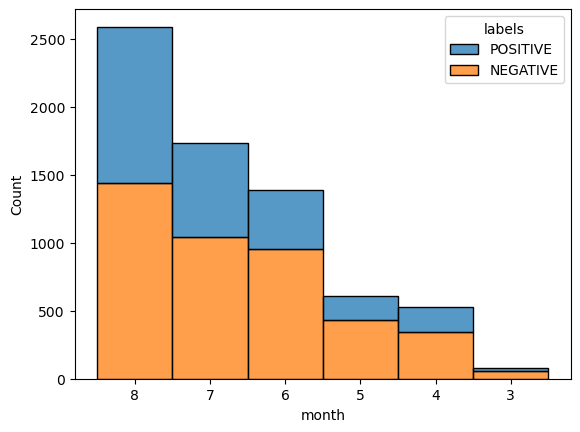

In [37]:
sns.histplot(data=data, x="month", hue="labels", multiple="stack")

<Axes: xlabel='majorVersion', ylabel='Count'>

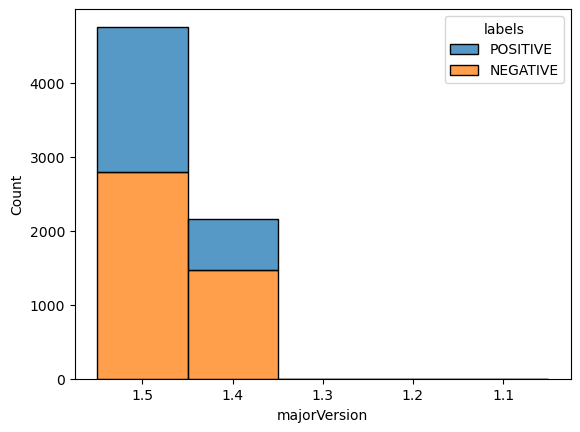

In [38]:
sns.histplot(data=data, x="majorVersion", hue="labels", multiple="stack")

<Axes: xlabel='labels', ylabel='thumbsUpCount'>

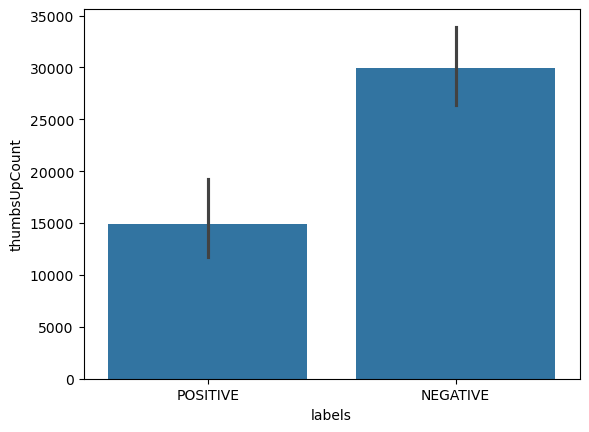

In [80]:
sns.barplot(data=data, x="labels", y="thumbsUpCount", estimator="sum")

In [40]:
negative = docs[docs['text_label']=='NEGATIVE']['text_lemitizing']
positive = docs[docs['text_label']=='POSITIVE']['text_lemitizing']

# Topic Analysis

In [42]:
embedding_model = pipeline("feature-extraction", model="princeton-nlp/sup-simcse-roberta-large")
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
vectorizer_model = CountVectorizer(min_df=10,ngram_range=(1, 3))
ctfidf_model = ClassTfidfTransformer(bm25_weighting=True)
representation_model = MaximalMarginalRelevance(diversity=0.3)

def topic(n_cluster):
    topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=AgglomerativeClustering(n_clusters=n_cluster),
    vectorizer_model=vectorizer_model,
    ctfidf_model=ctfidf_model,
    representation_model=representation_model,
    calculate_probabilities=True,
    verbose=True,
    )
    return topic_model

config.json:   0%|          | 0.00/664 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0


## Negative Topic

In [43]:
negative_topic = topic(25)
negative_info = negative_topic.fit_transform(negative)
negative_info = negative_topic.get_topic_info()
negative_info.to_excel('negative_topic.xlsx')
negative_info

2025-08-31 06:27:56,044 - BERTopic - Embedding - Transforming documents to embeddings.
100% 4265/4265 [00:18<00:00, 232.09it/s]
2025-08-31 06:28:14,433 - BERTopic - Embedding - Completed ✓
2025-08-31 06:28:14,434 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-31 06:28:23,661 - BERTopic - Dimensionality - Completed ✓
2025-08-31 06:28:23,662 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-31 06:28:23,844 - BERTopic - Cluster - Completed ✓
2025-08-31 06:28:23,845 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-31 06:28:26,764 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,0,385,0_money_balance cut_didnt_account,"[money, balance cut, didnt, account, transacti...",[disappointed dont transfer bank there history...
1,1,296,1_package_app_email_gopay app,"[package, app, email, gopay app, im trying, mo...",[c didnt respond im trying change data update ...
2,2,267,2_voucher_cashback_game_wdp,"[voucher, cashback, game, wdp, promo, free, in...",[didnt get bought free fire diamond household ...
3,3,265,3_app_gopay app_apk_sent,"[app, gopay app, apk, sent, problem, cant, dow...",[app doesnt support often come open app doesnt...
4,4,265,4_promo_code_discount_ad,"[promo, code, discount, ad, buy, wdp, voucher,...",[every time there promo using reedem code ther...
5,5,227,5_account_phone_delete_cant log,"[account, phone, delete, cant log, gopay accou...",[difficult log pin already plus facial verific...
6,6,219,6_network_internet_latest_apk,"[network, internet, latest, apk, cant log, app...",[im disappointed downloaded app want updated l...
7,7,212,7_yet_report_hasnt come_bank,"[yet, report, hasnt come, bank, ive waiting, c...",[cooking topup two day didnt come bni sender b...
8,8,201,8_lost_im disappointed_transferred_gopay app,"[lost, im disappointed, transferred, gopay app...",[ive comfortable using app since yesterday inc...
9,9,198,9_bank_transaction_cant_account,"[bank, transaction, cant, account, want transf...",[wow many bug many problem etc problem want tr...


In [44]:
negative_topic.set_topic_labels({
    0: "Login & Account Access", 1: "Balance Not Credited", 2: "Facial Verification Failed", 3: "Customer Service Delay",4: "App Performance Issues",
    5: "Promo Voucher Failure", 6: "GoPay Plus Account Issues", 7: "Balance Cuts & Missing Top-ups",8: "Loan Denied", 9: "App Bugs & Errors",
    10: "Promo & Gift Frustration", 11: "Connectivity & Chat Issues", 12: "Fewer Discounts", 13: "Unreliable Game Top-ups", 14: "Balance Deducted Without Funds",
    15: "Delayed Bank Transfers", 16: "Missing Cashback/Promo", 17: "Cannot Claim Gifts/Promo", 18: "Top-up Deducted, Not Credited", 19: "Recent Top-ups Not Reflected",
    20: "Account Access Problems", 21: "Mandatory App Update Blocks Login", 22: "Delayed Balance After Bank Top-up", 23: "Payment/Service Access Blocked", 24: "Update Prompts & Intrusive Ads"
})

negative_info = negative_topic.get_document_info(negative)
negative_info["Sub Topic"] = negative_info["CustomName"]
negative_info = negative_info[["Document","Topic", "Sub Topic"]]
negative_info

,Document,Topic,Sub Topic
0,please reduce unnecessary animation lighten ap...,6,GoPay Plus Account Issues
1,app good others there lot weirdness like spin ...,2,Facial Verification Failed
2,im pretty disappointed update time current gop...,8,Loan Denied
3,promo unrealistic price turn expensive app ive...,3,Customer Service Delay
4,first shs fine shes often interrupted continui...,13,Unreliable Game Top-ups
...,...,...,...
4260,cant get code sent,3,Customer Service Delay
4261,im transferring gopay havent since pm,22,Delayed Balance After Bank Top-up
4262,dont let anyone else download apk gojeck stuff...,3,Customer Service Delay
4263,clear long effort wait till g get wdp rupiah u...,12,Fewer Discounts


In [45]:
def get_topic_group(topic_number):
    if topic_number in [0, 6, 20, 21, 23]:
        return "Login & Account Access"
    elif topic_number in [1, 7, 14, 15, 18, 19, 22]:
        return "Balance & Transaction History"
    elif topic_number in [2, 8]:
        return "Verification & Loan Issues"
    elif topic_number == 3:
        return "Customer Service"
    elif topic_number in [4, 9, 11, 24]:
        return "App Performance & Features"
    else:
        return "Promotions, Vouchers & Cashback"

negative_info["Main Topic"] = negative_info["Topic"].progress_apply(get_topic_group)
negative_info = negative_info[["Document","Main Topic", "Sub Topic"]]

negative = data[data['labels']=='NEGATIVE'][["thumbsUpCount","month", "minorVersion","majorVersion"]]
negative_info = pd.concat([negative_info.reset_index(drop=True), negative.reset_index(drop=True)], axis=1)
negative_info

100% 4265/4265 [00:00<00:00, 819905.88it/s]


,Document,Main Topic,Sub Topic,thumbsUpCount,month,minorVersion,majorVersion
0,please reduce unnecessary animation lighten ap...,Login & Account Access,GoPay Plus Account Issues,3,8,1.57.0,1.5
1,app good others there lot weirdness like spin ...,Verification & Loan Issues,Facial Verification Failed,26,8,1.56.1,1.5
2,im pretty disappointed update time current gop...,Verification & Loan Issues,Loan Denied,22,8,1.56.1,1.5
3,promo unrealistic price turn expensive app ive...,Customer Service,Customer Service Delay,26,8,1.53.0,1.5
4,first shs fine shes often interrupted continui...,"Promotions, Vouchers & Cashback",Unreliable Game Top-ups,0,8,1.57.0,1.5
...,...,...,...,...,...,...,...
4260,cant get code sent,Customer Service,Customer Service Delay,0,6,1.47.0,1.4
4261,im transferring gopay havent since pm,Balance & Transaction History,Delayed Balance After Bank Top-up,0,7,1.53.0,1.5
4262,dont let anyone else download apk gojeck stuff...,Customer Service,Customer Service Delay,0,7,1.45.0,1.4
4263,clear long effort wait till g get wdp rupiah u...,"Promotions, Vouchers & Cashback",Fewer Discounts,0,7,1.52.0,1.5


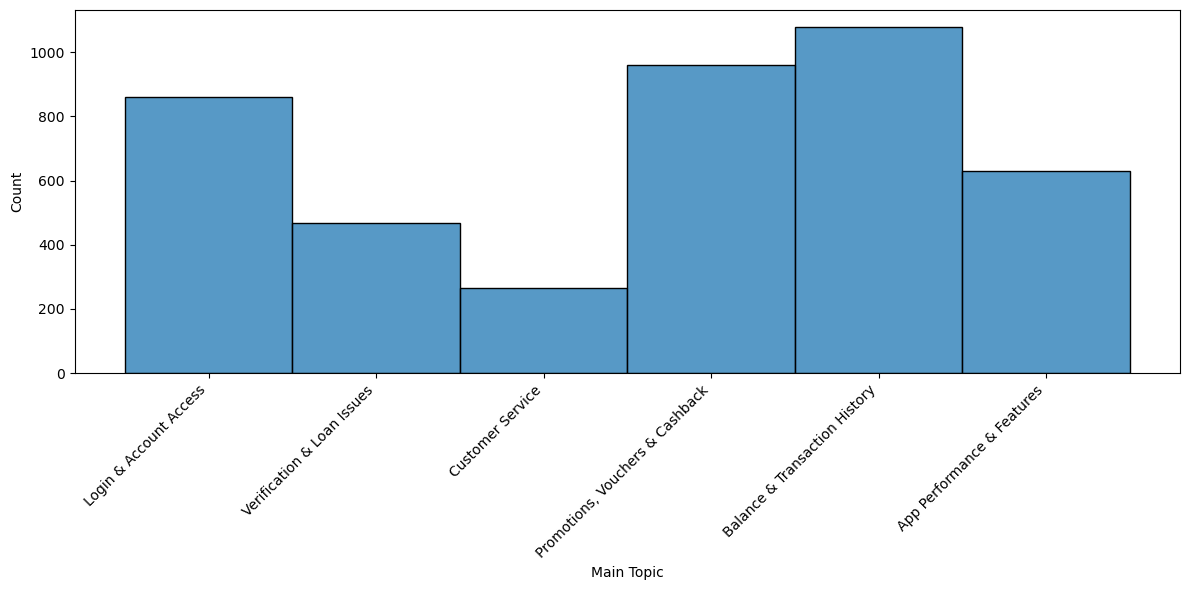

In [65]:
plt.figure(figsize=(12, 6))
sns.histplot(data=negative_info, x="Main Topic")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

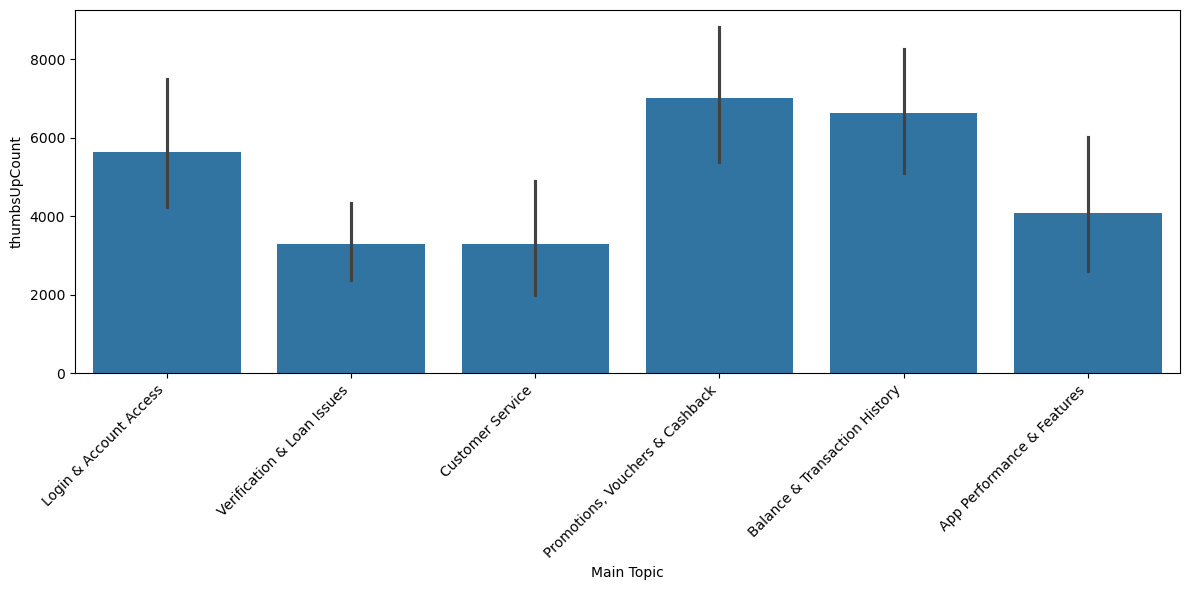

In [67]:
plt.figure(figsize=(12, 6))
sns.barplot(data=negative_info, x="Main Topic", y="thumbsUpCount", estimator='sum')

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

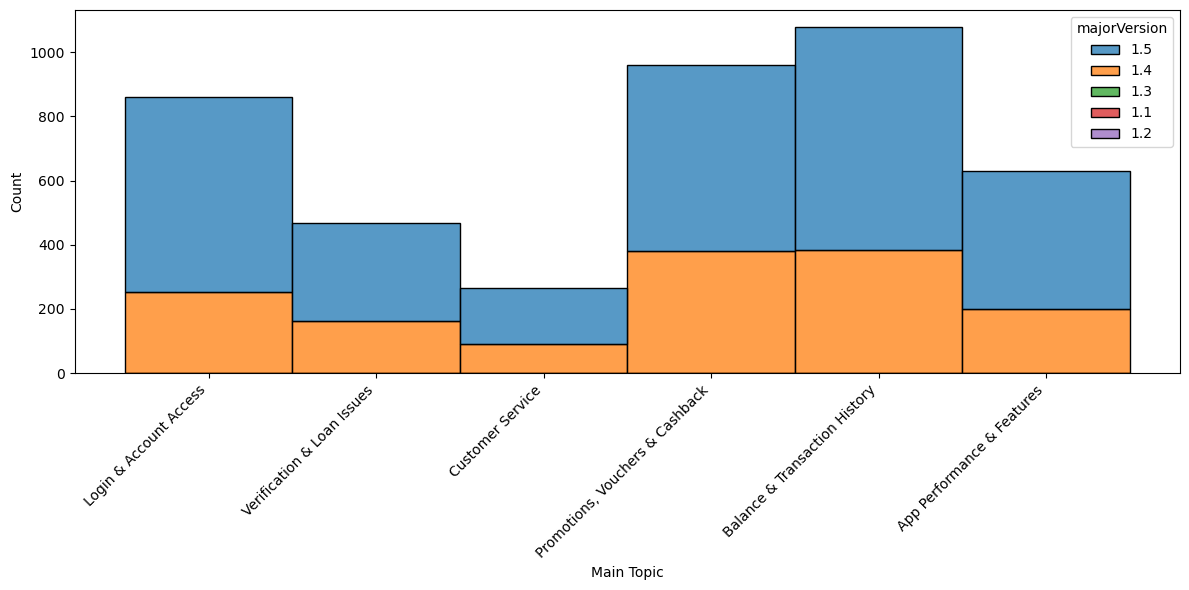

In [76]:
plt.figure(figsize=(12, 6))
sns.histplot(data=negative_info, x="Main Topic", hue="majorVersion", multiple="stack")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
negative_info = negative_topic.get_topic_info()
negative_info

## Positive Topic

In [82]:
positive_topic = topic(12)
positive_info = positive_topic.fit_transform(positive)
positive_info = positive_topic.get_topic_info()
positive_info.to_excel('positive_topic.xlsx')
positive_info

2025-08-31 07:30:46,618 - BERTopic - Embedding - Transforming documents to embeddings.
100% 2656/2656 [00:10<00:00, 244.43it/s]
2025-08-31 07:30:57,491 - BERTopic - Embedding - Completed ✓
2025-08-31 07:30:57,492 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-31 07:31:04,761 - BERTopic - Dimensionality - Completed ✓
2025-08-31 07:31:04,761 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-31 07:31:04,817 - BERTopic - Cluster - Completed ✓
2025-08-31 07:31:04,819 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-31 07:31:06,210 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,0,509,0_thank_gopay_pulse_app,"[thank, gopay, pulse, app, free, transaction, ...",[gopay app helpful life im easily transacting ...
1,1,290,1_please_easy_simple_helpful,"[please, easy, simple, helpful, process, easie...",[please please please please please please ple...
2,2,279,2_balance_still_transaction_time,"[balance, still, transaction, time, already, t...",[top gopay balance fund entry balance fund cut...
3,3,269,3_want_long_problem_apk,"[want, long, problem, apk, like, sometimes, he...",[ive using promo loading long time signal good...
4,4,260,4_transaction_easy_payment_transfer,"[transaction, easy, payment, transfer, helpful...","[transaction smooth easy, easy helpful transac..."
5,5,248,5_app_application_transaction_like,"[app, application, transaction, like, service,...","[good app easy use make transaction anywhere, ..."
6,6,212,6_game_cheap_great_promotion,"[game, cheap, great, promotion, free, like, gi...",[good there game finding coin well top game le...
7,7,144,7_application_helpful_app_easy,"[application, helpful, app, easy, user, good, ...","[app helpful easy use, app helpful easy use, a..."
8,8,143,8_promotion_bonus_cheap_many,"[promotion, bonus, cheap, many, free, great, e...",[big deal sign guaranteed security lot promoti...
9,9,106,9_give_transaction_want_pay,"[give, transaction, want, pay, sometimes, help...",[system busy press keep busy press keep busy p...


In [ ]:
positive_topic.set_topic_labels({
    0: "Login & Account Access", 1: "Balance Not Credited", 2: "Facial Verification Failed", 3: "Customer Service Delay",4: "App Performance Issues",
    5: "Promo Voucher Failure", 6: "GoPay Plus Account Issues", 7: "Balance Cuts & Missing Top-ups",8: "Loan Denied", 9: "App Bugs & Errors",
    10: "Promo & Gift Frustration", 11: "Connectivity & Chat Issues", 12: "Fewer Discounts", 13: "Unreliable Game Top-ups", 14: "Balance Deducted Without Funds",
    15: "Delayed Bank Transfers", 16: "Missing Cashback/Promo", 17: "Cannot Claim Gifts/Promo", 18: "Top-up Deducted, Not Credited", 19: "Recent Top-ups Not Reflected",
    20: "Account Access Problems", 21: "Mandatory App Update Blocks Login", 22: "Delayed Balance After Bank Top-up", 23: "Payment/Service Access Blocked", 24: "Update Prompts & Intrusive Ads"
})

positive_info = positive_topic.get_document_info(positive)
positive_info["Sub Topic"] = negative_info["CustomName"]
positive_info = positive_info[["Document","Topic", "Sub Topic"]]
positive_info

In [ ]:
def get_topic_group(topic_number):
    if topic_number in [0, 6, 20, 21, 23]:
        return "Login & Account Access"
    elif topic_number in [1, 7, 14, 15, 18, 19, 22]:
        return "Balance & Transaction History"
    elif topic_number in [2, 8]:
        return "Verification & Loan Issues"
    elif topic_number == 3:
        return "Customer Service"
    elif topic_number in [4, 9, 11, 24]:
        return "App Performance & Features"
    else:
        return "Promotions, Vouchers & Cashback"

positive_info["Main Topic"] = positive_info["Topic"].progress_apply(get_topic_group)
positive_info = positive_info[["Document","Main Topic", "Sub Topic"]]

positive = data[data['labels']=='NEGATIVE'][["thumbsUpCount","month", "minorVersion","majorVersion"]]
positive_info = pd.concat([positive_info.reset_index(drop=True), positive.reset_index(drop=True)], axis=1)
positive_info

positive_info = positive_topic.get_topic_info()
positive_info

# Conclusion